In [1]:
import pandas as pd

In [5]:
train = pd.read_csv('data/train.csv')

In [6]:
train.shape

(27481, 4)

In [8]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [9]:
test = pd.read_csv('data/test.csv')

In [10]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [11]:
import seaborn as sns

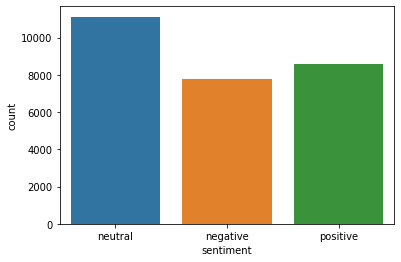

In [13]:
_ = sns.countplot(train.sentiment)

Question 1: For neutral sentiment tweets, are text and selected text columns same?

In [16]:
neutral = train[train.sentiment=='neutral']

In [18]:
len(neutral), sum(neutral.text == neutral.selected_text)

(11118, 5930)

Around half of the tweets with sentiment = 'neutral' are same

Let's look at neutral tweets where text != selected_text

In [25]:
pd.set_option('display.max_colwidth', -1)  # to display all the text

In [26]:
neutral[neutral.text != neutral.selected_text].sample(n=10)
# randomly pick 10 rows

,textID,text,selected_text,sentiment
199,7a718b23ef,_Sanderson What`s with Twatter lately? Either I can`t get on or the replies don`t turn up!,What`s with Twatter lately? Either I can`t get on or the replies don`t turn up!,neutral
19458,7dad90e273,"I spoke too soon Still a nice evening, but lots of broken cloud coming in from the south.","I spoke too soon Still a nice evening, but lots of broken cloud coming in from the south.",neutral
26472,68a56eca92,"..uuuups today is mother day???....sh***....iï¿½ve forgot it, my work doesnï¿½t have a end *sigh*....thank you for remind it","..uuuups today is mother day???....sh***....iï¿½ve forgot it, my work doesnï¿½t have a end *sigh*....thank you for remind it",neutral
2931,b1e3728694,I hope when you`re calling this the shitshow you mean that in a good way. because this will be fun.,e when you`re calling this the shitshow you mean that in a good way. because this will be fun.,neutral
12905,20486c94d2,why!!!! u have to bring it to you 24/7 like the _team,why!!!! u have to bring it to you 24/7 like the _team,neutral
22492,9954cca530,my *mom*(not aunt haha) and uncle were both adopted with very diff adoptive stories. if you want to chat sometime lmk,my *mom*(not aunt haha) and uncle were both adopted with very diff adoptive stories. if you want to chat sometime lmk,neutral
15505,f62728e9d7,"well, someone told me it`s only there for two weeks i`m going again next week with a friend IN SCHOOL TIME :p ...","well, someone told me it`s only there for two weeks i`m going again next week with a friend IN SCHOOL TIME :p ..",neutral
16951,a181702898,i can`t call you cause my portable sais that this number not excist i want so much to talk to you,i can`t call you cause my portable sais that this number not excist i want so much to talk to you,neutral
11173,4d3e3aeb24,You really think it was that awesome? We`ll have to discuss,You really think it was that awesome? We`ll have to discuss,neutral
8964,4eab36d2d2,tea... Mmmm crispy but no cake Have headphones!,tea... Mmmm crispy but no cake Have headphones!,neutral


These tweets look similar.
Are there trailing spaces or space at the beginning of strings?

In [32]:
row = neutral.loc[19458,:]

In [34]:
row.text.strip() == row.selected_text.strip()

True

We need to remove these leading and trailing spaces. Also for calculating jaccard similar during evaluationg these trailing and leading spaces will not affect the score.

In [36]:
train.text = train.text.str.strip()
train.selected_text = train.selected_text.str.strip()

In [37]:
neutral = train[train.sentiment=='neutral']

In [38]:
len(neutral), sum(neutral.text == neutral.selected_text)

(11118, 10004)

Well, 90% of the neutral tweets have same text and selected_text.

In orde to get better sense of data, Let's look at neutral tweets where text != selected_text

In [40]:
neutral[neutral.text != neutral.selected_text].sample(n=10)

,textID,text,selected_text,sentiment
1356,7651967ec9,"i want some grape soda, jack fowers` fault. also, i wish i could see you play are your uk gigs sold out? please reply!!!!!!!!","fault. also, i wish i could see you play are your uk gigs sold out? please reply!!!!!!!!",neutral
1758,f9147427db,that David -- nice to know he feels so comfortable 'twitting' or 'tweeting' us. I have a feeling he misses home.,nice to know he feels so comfortable 'twitting' or 'tweeting' us. I have a feeling he misses home,neutral
3344,eb789743a8,"Thanks for the tip! Unfortunately a major crash in my https site, just as ExtPlorer","Thanks for the tip! Unfortunately a major crash in my https site,",neutral
17666,5eff927ac5,That mango shake made ALL the difference. - http://tweet.sg,That mango shake made ALL the difference.,neutral
8902,3412e405af,Brad Paisley+Alison Krauss- Whiskey Lullaby...so sad but its awesome!,so sad but its awesome!,neutral
15167,999d9eb8aa,http://twitpic.com/66y00 - Niceee Hey i never get stickersss,Niceee Hey i never get stickersss,neutral
18398,644702023f,Hmm...what to make for dinner tonight??? No clue. Don`t feel like cooking anything Hubby wants to go away tonight.,Hmm...what to make for dinner tonight??? No clue. Don`t feel like cooking anything Hubby wants to go away tonigh,neutral
7108,dd8b781cd9,"Good night. Sorry I missed you during our morning window. See you at 5, I suspect.","Good night. Sorry I missed you during our morning window. See you at 5, I suspect",neutral
18240,6fbe1bf447,I`m still thinking ... Idk,I`m still thinking,neutral
3264,4f5f302b6d,": Omg! I never got your message so I didn`t notice until I was looking back a ways! Sorry, that was a good idea though...lol","Omg! I never got your message so I didn`t notice until I was looking back a ways! Sorry, that was a good idea though...lol",neutral
